In [38]:
import tensorflow as tf

import keras

import numpy as np
import matplotlib.pyplot as plt

from IPython import display


import pandas as pd
%matplotlib inline

In [2]:
from keras.layers import Input, RepeatVector, Dense, Embedding, Activation, Masking, Concatenate, Flatten, Conv1D, MaxPool1D
from keras.models import Model, Sequential
from keras import backend as K

from keras.utils import to_categorical

#from keras.backend import layers

In [3]:
import pickle

In [4]:
from sklearn.model_selection import train_test_split

In [7]:

w = np.ones((4,3)) * np.arange(3) 

In [8]:
d = np.array([[1, 2], [2, 0]])

In [9]:
w.T[d]

array([[[1., 1., 1., 1.],
        [2., 2., 2., 2.]],

       [[2., 2., 2., 2.],
        [0., 0., 0., 0.]]])

In [ ]:
Embedding()

In [8]:
class EmbeddingLayer:
    def __init__(self, name, emb_w):
        self.name = name
        with tf.variable_scope(self.name, reuse = tf.AUTO_REUSE):
            if type(emb_w) == tf.Variable:
                self.W = emb_w
            else:
#                if emb_w.shape[0] == len(vocab):
                self.W = tf.get_variable("emb_matrix", initializer=emb_w, dtype=tf.float32)
#                 else:
#                     emb_w_with_zero = np.vstack((np.zeros((1, emb_w.shape[1])), emb_w))
#                     self.W = tf.get_variable("emb_matrix", initializer=emb_w_with_zero)
    
    def __call__(self, inp):
        with tf.variable_scope(self.name, reuse = True):
            return tf.gather(self.W, tf.cast(inp, tf.int32))

In [39]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [19]:
test_x_0 = tf.placeholder(dtype = tf.int32)#, shape = [None, None])
test_x_1 = tf.placeholder(dtype = tf.int32)#, shape = [None, None])

In [20]:
emb = EmbeddingLayer("emb_1", tf.Variable(w.T))

In [21]:
test_y_1 = emb(test_x_0)
test_y_2 = emb(test_x_1)

In [22]:
sess.run(tf.global_variables_initializer())

In [23]:
sess.run(emb.W)

array([[0., 0., 0., 0.],
       [1., 1., 1., 1.],
       [2., 2., 2., 2.]])

In [24]:
d

array([[1, 2],
       [2, 0]])

In [25]:
sess.run(test_y_2, {test_x_0 : d, test_x_1: np.array([[1]])})

array([[[1., 1., 1., 1.]]])

In [26]:
gr = tf.get_default_graph()

In [27]:
writer = tf.summary.FileWriter("../tf_logs", gr)

In [30]:
gr.get_name_scope()

''

In [35]:
gr.collections

['variables', 'trainable_variables', ('__varscope',), ('__variable_store',)]

In [38]:
gr.get_collection('trainable_variables')

[<tf.Variable 'Variable:0' shape=(3, 4) dtype=float64_ref>]

#  LOAD + PREP DATA

In [5]:
X_0 = np.load("../data/Dv_PB/X_0.npy")[:, 1:-1]
X_1 = np.load("../data/Dv_PB/X_1.npy")[:, 1:-1]
X_2 = np.load("../data/Dv_PB/X_2.npy")[:, 1:-1]
y = np.load("../data/Dv_PB/y.npy")

In [6]:
print(X_0.shape,X_1.shape,X_2.shape, y.shape)

(104592, 8) (104592, 9) (104592, 15) (104592,)


#### Net

In [7]:
class SequenceProcessHead:
    def __init__(self, name, size=10):
        self.name = name
        with tf.variable_scope(name, tf.AUTO_REUSE):
            self.convolutions = [Conv1D(64, 3), Conv1D(128, 3), Conv1D(256, 3)]
    
    def __call__(self, inp):
        with tf.variable_scope(self.name, tf.AUTO_REUSE):
            curr = inp
            for conv in self.convolutions:
                curr = conv(curr)

            return curr
    

In [9]:
class MultiheadEmbNet:
    def __init__(self, name, n_heads, emb_matrix = None, return_heads=False):
        self.name = name
        self.n_heads = n_heads
        self.return_heads = return_heads
        with tf.variable_scope(name):
            
            if not emb_matrix is None:
                self.emb_W = emb_matrix.astype(np.float32)
                self.emb_layer = EmbeddingLayer('emb', self.emb_W)
            else:
                self.emb_layer = Embedding(24, 32)
            self.heads = [SequenceProcessHead("head_" + str(i)) for i in range(self.n_heads)]
            self.conc = Concatenate(1)
            self.flatten = Flatten()
            self.out = Dense(2)            
        
        
    def __call__(self, inp):
        return self.predict_logits(inp)
        
    def predict_logits(self, inp):
        if len(inp) != self.n_heads:
            raise ValueError("input should be list, with len(inp) equals to heads number, {}, {}"
                             .format(str(len(inp)), str(self.n_heads)))
        #with tf.variable_scope(self.name, reuse=tf.AUTO_REUSE):
        #from IPython.core.debugger import Tracer; Tracer()() 
        embedded_inps = [self.emb_layer(x) for x in inp]
        processed = [head(x) for (head, x) in zip(self.heads, embedded_inps)]
        concatenated = self.conc(processed)
        flatted = self.flatten(concatenated)
        pred = self.out(flatted)
        
        if self.return_heads:
            return pred, processed
        else:
            return pred
        
        
#     def _new_head(self, input_tensor, out_shape, head_num=0):
#         with tf.variable_scope('head_' + str(head_num)):
#             emb = EmbeddingLayer('embedding', self.emb_W)(input_tensor)
#             dense_1 = Dense(10, activation = tf.nn.relu)(emb)
        
#         return dense_1


In [10]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [11]:
test_x_0 = tf.placeholder(dtype = tf.int32, shape = [None, 8])
test_x_1 = tf.placeholder(dtype = tf.int32, shape = [None, 9])
test_x_2 = tf.placeholder(dtype = tf.int32, shape = [None, 15])#, shape = [None, None])

In [12]:
gorynych = MultiheadEmbNet('gorynych', 3)

In [13]:
out_logits = gorynych.predict_logits([test_x_0, test_x_1, test_x_2])

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [22]:
target = tf.placeholder(dtype = tf.float32, shape = [None, 2])

In [23]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=target, logits=out_logits))

In [24]:
optimizer = tf.train.AdamOptimizer(beta2=0.98)

In [25]:
train_step = optimizer.minimize(loss)


In [26]:
sess.run(tf.global_variables_initializer())

In [27]:
gr = tf.get_default_graph()

In [28]:
writer = tf.summary.FileWriter("../tf_logs", gr)

In [15]:
idx = np.arange(y.shape[0])
train_idx, test_idx = train_test_split(idx)

In [16]:
X_0_train, X_0_test = X_0[train_idx], X_0[test_idx]
X_1_train, X_1_test = X_1[train_idx], X_1[test_idx]
X_2_train, X_2_test = X_2[train_idx], X_2[test_idx]

y_train, y_test = y[train_idx], y[test_idx]

In [32]:
def iterate_minibatches(inputs, y, batchsize, shuffle=True):
    if shuffle:
        indices = np.arange(y.shape[0])
        np.random.shuffle(indices)
    for start_idx in range(0, y.shape[0] - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield [x[excerpt] for x in inputs], y[excerpt]

In [31]:
sess.run(loss, feed_dict={test_x_0 : X_0_train[:20],
                        test_x_1 : X_1_train[:20],
                        test_x_2 : X_2_train[:20],
                        target: to_categorical(y[:20], 2)})

0.5339229

In [36]:
losses_each_n = []
n = 50
curr_loss = 0

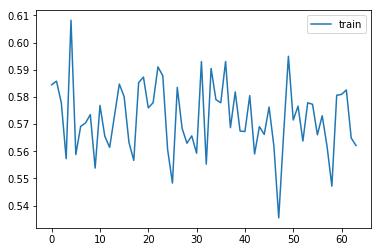

KeyboardInterrupt: 

In [39]:
for i, (batch_X, batch_y) in enumerate(iterate_minibatches([X_0_train, X_1_train, X_2_train], y_train, 20)):
    
    batch_loss = sess.run([train_step,loss], feed_dict={test_x_0 : batch_X[0],
                                                   test_x_1 : batch_X[1],
                                                   test_x_2 : batch_X[2],
                                                   target: to_categorical(batch_y, 2)})
    curr_loss += batch_loss[1]
    
    if i % n == 0 and i != 0:
        losses_each_n.append( curr_loss / n)
        curr_loss = 0
        
           
        display.clear_output(wait=True)
        plt.plot(losses_each_n, label='train')
        #plt.plot(v_losses_valid[1:], label='test')
        plt.legend()
        plt.show()
    
    #print(batch_loss[1])

In [135]:
[x for x in iterate_minibatches([X_0_train, X_1_train, X_2_train], y_train, 20)]

[]